Ideas are got from [Megan Risdal](https://www.kaggle.com/mrisdal/shelter-animal-outcomes/quick-dirty-randomforest).

## Preprocessing data / data exploration

### dealing with missing data

+ remove the column containing that missing data
+ remove the row containing that missing data
+ fill missing data with the mean of that column
+ fill missing data with 0
+ fill missing data with the most frequency value

### transform data

+ convert categorical data to numerical
+ make all feature have the same scale
+ one-hot encoding

### import some standard packages to use

+ **pandas**: similar to excel
+ **numpy/scipy**: similar to matlab
+ **matplotlib/seaborn**: to visualize
+ to install a package, type:  `conda install name_of_package` in the command line

In [1]:
# import standard libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

### Load data

In [2]:
# load data
train_data = pd.read_csv("data/train.csv", index_col="AnimalID")
test_data = pd.read_csv("data/test.csv", index_col="ID")

### Look at the data

In [3]:
train_data.head(3)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White


In [4]:
test_data.head()

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
ID,,,,,,,
1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### remove unnecessary columns

In [5]:
train_data.drop("OutcomeSubtype", axis=1, inplace=True)

### summary information of data

In [6]:
# check all categorical columns
print("Shape of train data:", train_data.shape)
for column in train_data.columns:
    print("Number of {0}: {1} and there is {2} NaN value.".format(column,
                                                                  len(train_data[column].unique()),
                                                                  train_data[column].isnull().sum()))

Shape of train data: (26729, 8)
Number of Name: 6375 and there is 7691 NaN value.
Number of DateTime: 22918 and there is 0 NaN value.
Number of OutcomeType: 5 and there is 0 NaN value.
Number of AnimalType: 2 and there is 0 NaN value.
Number of SexuponOutcome: 6 and there is 1 NaN value.
Number of AgeuponOutcome: 45 and there is 18 NaN value.
Number of Breed: 1380 and there is 0 NaN value.
Number of Color: 366 and there is 0 NaN value.


In [7]:
print("Shape of test data:", test_data.shape)
for column in test_data.columns:
    print("Number of {0}: {1} and there is {2} NaN value.".format(column,
                                                                  len(test_data[column].unique()),
                                                                  test_data[column].isnull().sum()))

Shape of test data: (11456, 7)
Number of Name: 3713 and there is 3225 NaN value.
Number of DateTime: 10575 and there is 0 NaN value.
Number of AnimalType: 2 and there is 0 NaN value.
Number of SexuponOutcome: 5 and there is 0 NaN value.
Number of AgeuponOutcome: 46 and there is 6 NaN value.
Number of Breed: 913 and there is 0 NaN value.
Number of Color: 277 and there is 0 NaN value.


#### Remark
+ DataTime: may be important (time of day, weekend vs weekday), tricky
+ Name: should be categorized into having name and not having name
+ OutcomeType: one hot encode
+ AnimalType: binary encode

+ SexuponOutcome: one hot encode, predict 1 missing value
+ Age -> regression; predict missing value (just take median)
+ Breed: should be grouped, tricky
+ Color: should be grouped, tricky

### Make visualization

#### First, look at the column names

In [8]:
train_data.columns

Index(['Name', 'DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome',
       'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

### OutcomeType distribution (target)

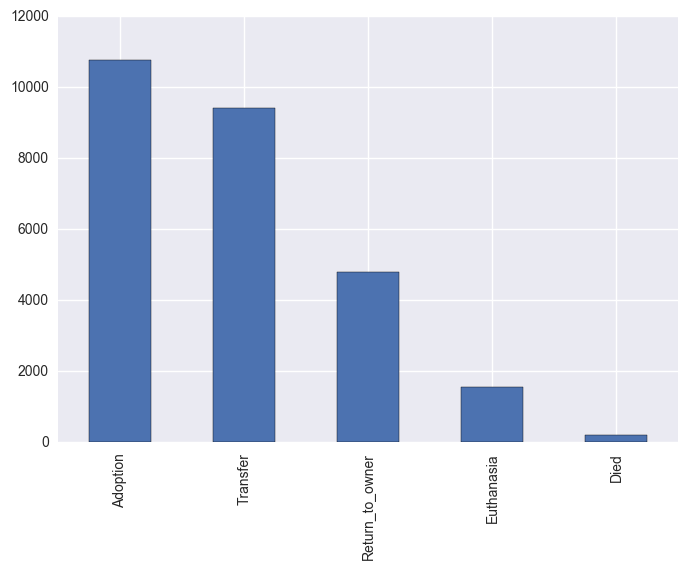

In [9]:
train_data["OutcomeType"].value_counts().plot(kind="bar")

#### Remark
+ Animals mostly adoption and transfer.
+ Just a few dies.

### Name vs OutcomeType
+ Some animal have name, some animal not have name

In [10]:
# divide into with name and without name
train_data["HasName"] = train_data["Name"].notnull()
test_data["HasName"] = test_data["Name"].notnull()

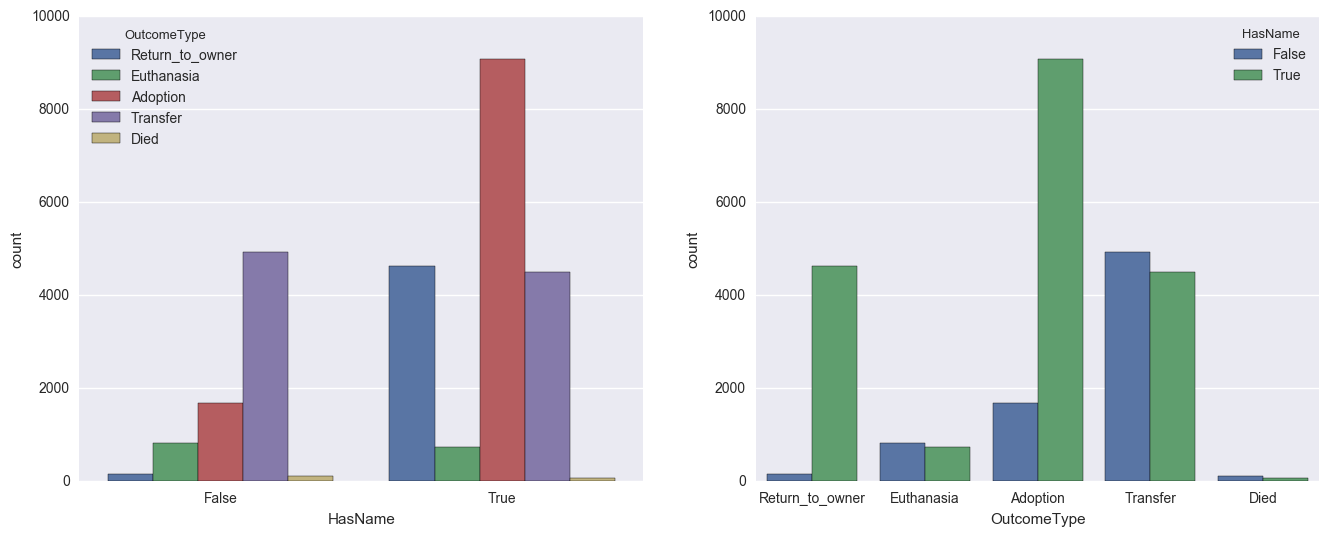

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(data=train_data, x="HasName", hue="OutcomeType", ax=axes[0])
sns.countplot(data=train_data, hue="HasName", x="OutcomeType", ax=axes[1])

#### Remark
+ Animals with name will rarely euthanasia or die.
+ Animals without name mostly be transfered.
+ So we can conclude that this feature is important.
+ Other conclusions are: within return to owner class and adoption class, animals most have names.

### AnimalType vs OutcomeType

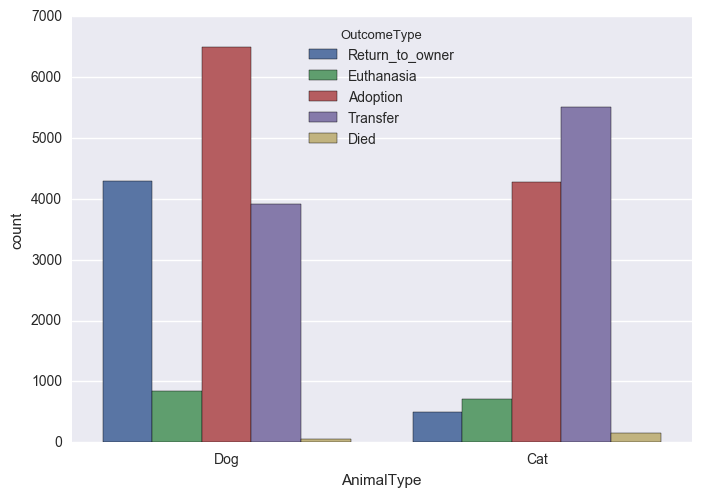

In [12]:
sns.countplot(data=train_data, x="AnimalType", hue="OutcomeType")

#### Remark
+ Dog will mostly return to owner comparing to cat.
+ Different distribution makes us conclude that this feature is also important.

### SexuponOutcome vs OutcomeType

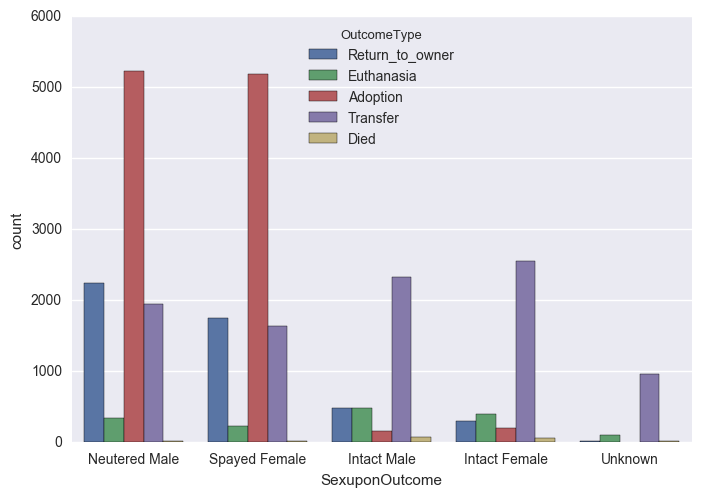

In [13]:
sns.countplot(data=train_data, x="SexuponOutcome", hue="OutcomeType")

+ intact male and female have similar distribution
+ not intact male and not intact female have similar distribution
+ so we make two new columns, one for intact or not, one for male or female

In [14]:
def isIntact(sex):
    if pd.isnull(sex) or sex == "Unknown":
        return "Unknown"
    else:
        return "Yes" if "Intact" in sex else "No"
        
    
def getSex(sex):
    if pd.isnull(sex) or sex == "Unknown":
        return "Unknown"
    else:
        return sex.split()[1]

train_data["Intact"] = train_data["SexuponOutcome"].apply(isIntact)
train_data["Sex"] = train_data["SexuponOutcome"].apply(getSex)
test_data["Intact"] = test_data["SexuponOutcome"].apply(isIntact)
test_data["Sex"] = test_data["SexuponOutcome"].apply(getSex)

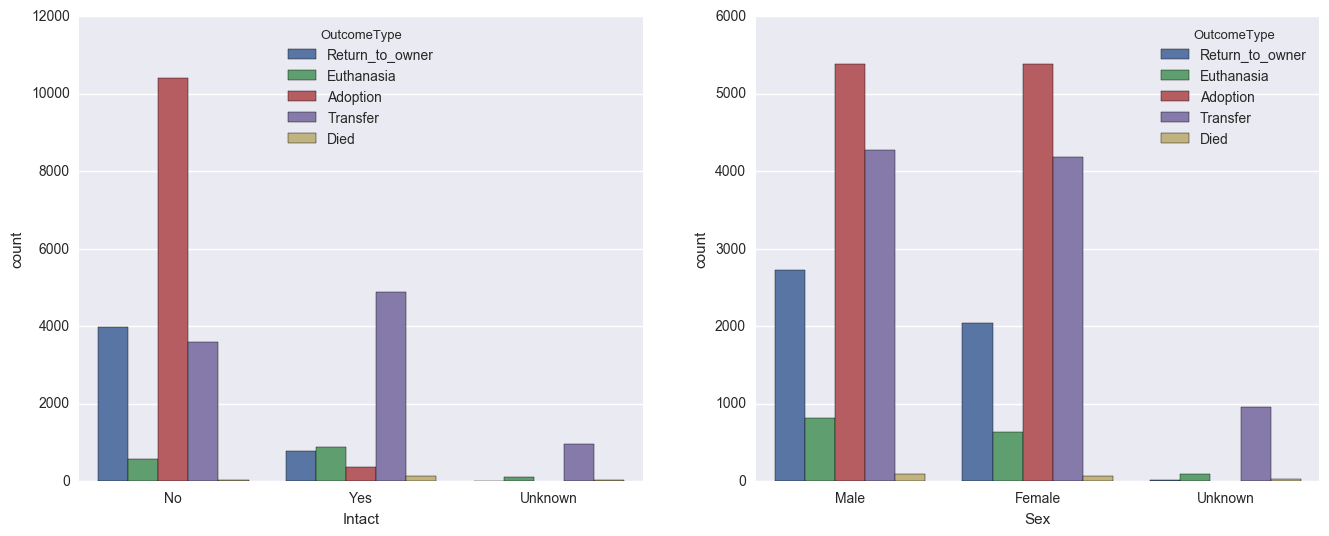

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.countplot(data=train_data, x="Intact", hue="OutcomeType", ax=axes[0])
sns.countplot(data=train_data, x="Sex", hue="OutcomeType", ax=axes[1])

#### Remark
+ Sex is not important feature; intact is a important feature.
+ Animals with intact are likely to be transfered.
+ In the "return to owner" and adoption groups, animals are mostly not intact.
+ Unknown group: mostly transfered.

### AgeuponOutcome vs OutcomeType

In [16]:
train_data["AgeuponOutcome"][:10]

AnimalID
A671945      1 year
A656520      1 year
A686464     2 years
A683430     3 weeks
A667013     2 years
A677334     1 month
A699218     3 weeks
A701489     3 weeks
A671784    5 months
A677747      1 year
Name: AgeuponOutcome, dtype: object

In [17]:
def convert_to_days(time):
    if pd.isnull(time):
        return np.nan
    else:
        num = int(time.split()[0])
        if "year" in time:
            return num * 365
        if "month" in time:
            return num * 30
        if "week" in time:
            return num * 7
        return num

train_data["AgeinDays"] = train_data["AgeuponOutcome"].apply(convert_to_days)
test_data["AgeinDays"] = test_data["AgeuponOutcome"].apply(convert_to_days)

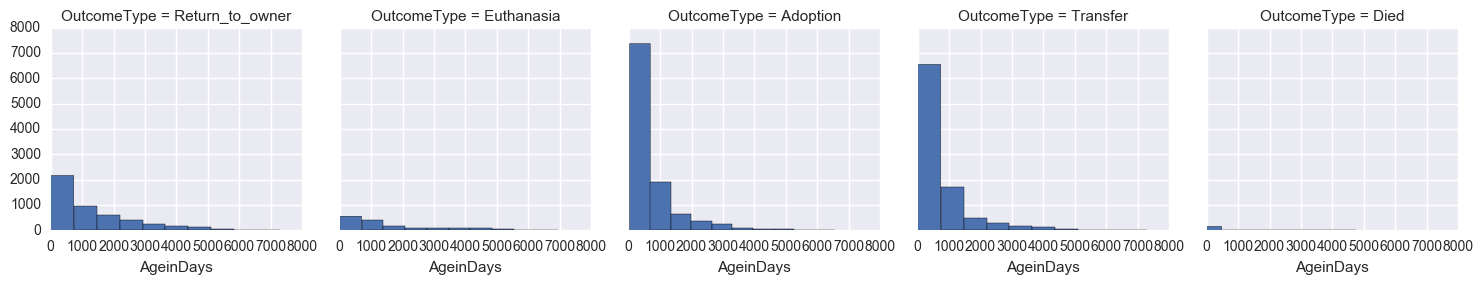

In [18]:
grid = sns.FacetGrid(train_data, col="OutcomeType")
grid.map(plt.hist, "AgeinDays")

#### may be there is different between baby and adult animal

In [19]:
def convert_to_stage(age):
    if pd.isnull(age):
        return np.nan
    else:
        return "baby" if age < 365 else "adult" 

train_data["Lifestage"] = train_data["AgeinDays"].apply(convert_to_stage) 

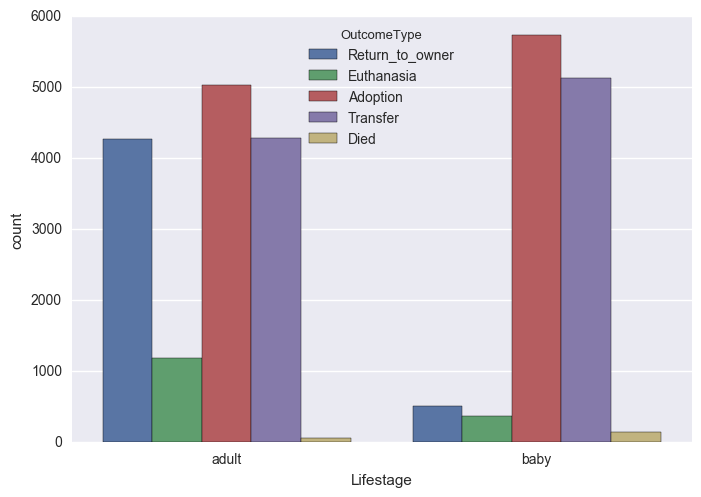

In [20]:
sns.countplot(data=train_data, x="Lifestage", hue="OutcomeType")

#### Remark
+ Most baby is adopted or transfer.
+ Adult is most likely returned to owner.
+ So AgeinDays is an important feature.

In [21]:
train_data.head(3) # review the data

,Name,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Intact,Sex,AgeinDays,Lifestage
AnimalID,,,,,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,True,No,Male,365.0,adult
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,True,No,Female,365.0,adult
A686464,Pearce,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,True,No,Male,730.0,adult


### DateTime vs OutcomeType

In [22]:
train_datetime = pd.DatetimeIndex(train_data["DateTime"].apply(pd.to_datetime))
train_data["Hour"] = train_datetime.hour
train_data["Weekday"] = train_datetime.weekday
train_data["Month"] = train_datetime.month
train_data["Year"] = train_datetime.year
test_datetime = pd.DatetimeIndex(test_data["DateTime"].apply(pd.to_datetime))
test_data["Hour"] = test_datetime.hour
test_data["Weekday"] = test_datetime.weekday
test_data["Month"] = test_datetime.month
test_data["Year"] = test_datetime.year

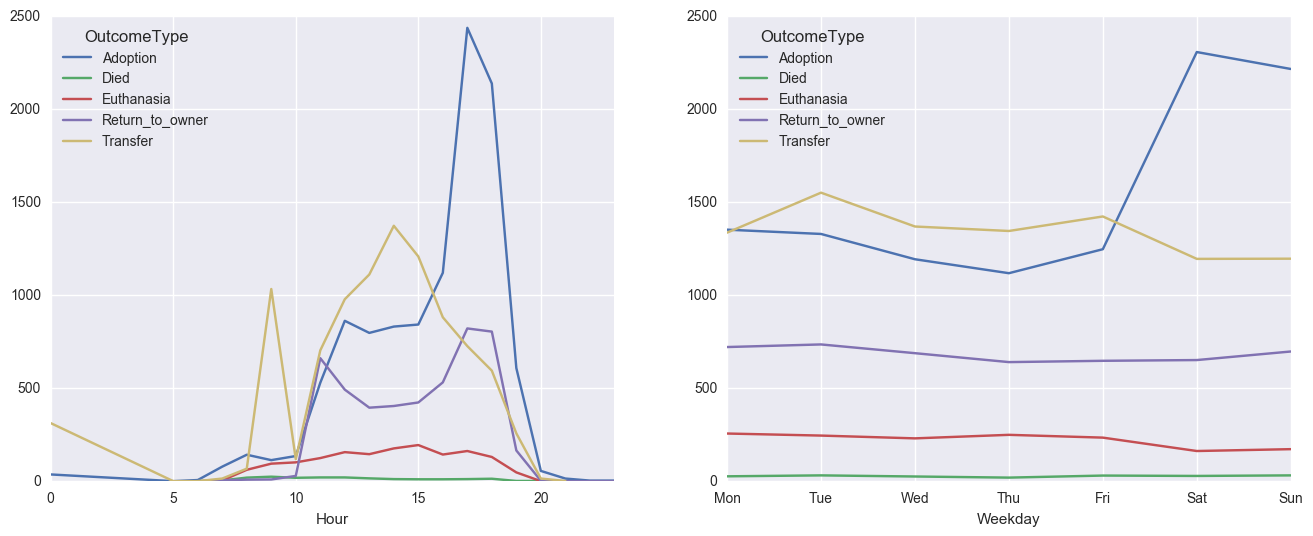

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
by_hour = train_data[["Hour", "OutcomeType"]].groupby(["Hour", "OutcomeType"]).size().unstack()
by_hour.plot(ax=axes[0])
by_weekday = train_data[["Weekday", "OutcomeType"]].groupby(["Weekday", "OutcomeType"]).size().unstack()
by_weekday.plot(ax=axes[1])
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

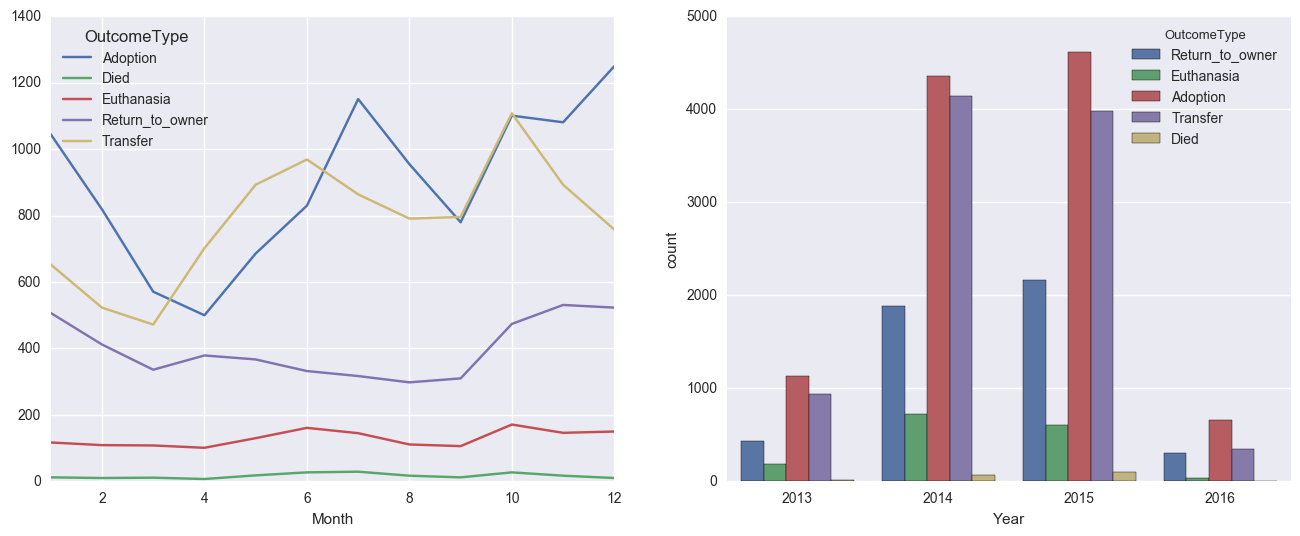

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
by_month = train_data[["Month", "OutcomeType"]].groupby(["Month", "OutcomeType"]).size().unstack()
by_month.plot(ax=axes[0])
sns.countplot(data=train_data, x="Year", hue="OutcomeType", ax=axes[1])

#### Remark
+ Adoption increases much in weekend.
+ At midnight, most animails is transfered.
+ Month plays important role in distinguishing adoption and transfer

### Breed vs OutcomeType
+ this is a complicated feature

In [25]:
train_data["Breed"][:10]

AnimalID
A671945                Shetland Sheepdog Mix
A656520               Domestic Shorthair Mix
A686464                         Pit Bull Mix
A683430               Domestic Shorthair Mix
A667013          Lhasa Apso/Miniature Poodle
A677334    Cairn Terrier/Chihuahua Shorthair
A699218               Domestic Shorthair Mix
A701489               Domestic Shorthair Mix
A671784        American Pit Bull Terrier Mix
A677747                        Cairn Terrier
Name: Breed, dtype: object

In [26]:
train_data["IsMix"] = train_data["Breed"].apply(lambda x: True if "Mix" in x else False)
test_data["IsMix"] = test_data["Breed"].apply(lambda x: True if "Mix" in x else False)

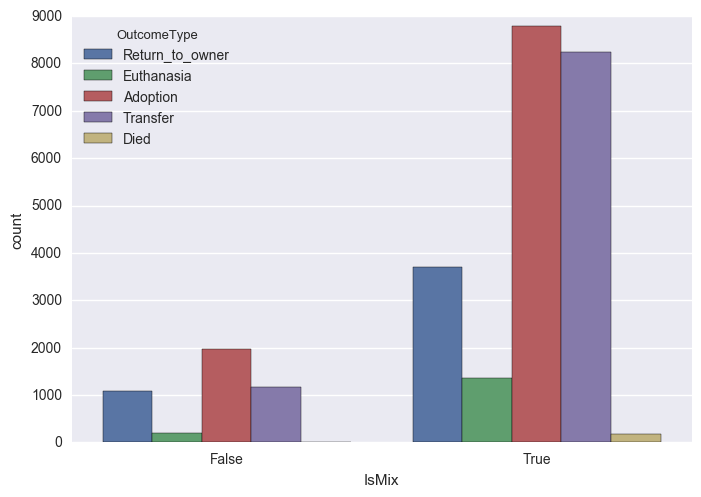

In [27]:
sns.countplot(data=train_data, x="IsMix", hue="OutcomeType")

#### Remark
+ If mix, then adoption and transfer are likely equal.
+ Maybe important.

### Color vs OutcomeType
+ another complicated feature

In [28]:
import re
train_data["SimpleColor"] = train_data["Color"].apply(lambda x: re.split("\W+", x)[0])
test_data["SimpleColor"] = test_data["Color"].apply(lambda x: re.split("\W+", x)[0])

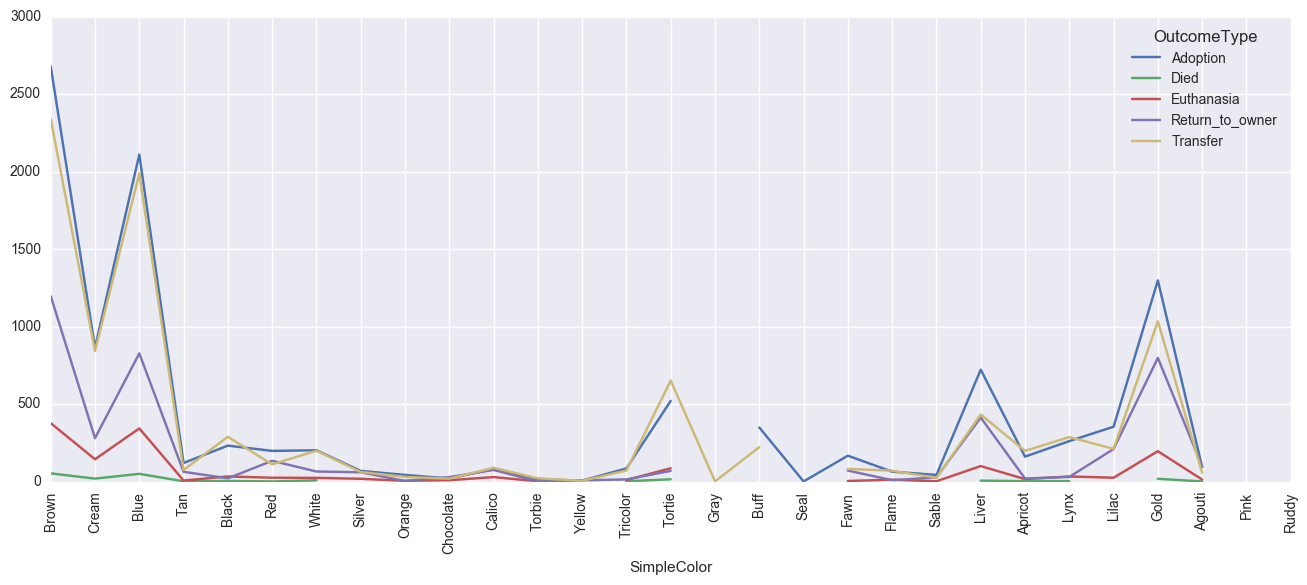

In [29]:
simple_colors = train_data["SimpleColor"].unique()
by_color = train_data[["SimpleColor", "OutcomeType"]].groupby(["SimpleColor", "OutcomeType"]).size().unstack()
ax = by_color.plot(xticks=range(2,len(simple_colors)+2), rot=90, xlim = (2,len(simple_colors)+1), figsize=(16,6))
ax.set_xticklabels(simple_colors);

#### Remark
+ It is quite a complicated feature, but it contains important information anyway.

### Dump data
+ to save data for future use

In [30]:
# train_data.to_pickle("train_data.pkl")
# test_data.to_pickle("test_data.pkl")

## Thank you!